# CA4

In [1]:
import matplotlib.pyplot as plt, numpy as np, torch, multiprocessing as mp
from torchvision import datasets, transforms
%matplotlib inline

## First let's get our data

In [2]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
idat = train_dataset.train_data
odat = train_dataset.train_labels

## Our support vector machine

In [3]:
class SVM(torch.nn.Sequential):
    
    def __init__(self):
        torch.nn.Sequential.__init__(self, torch.nn.Linear(28*28, 1))
        torch.manual_seed(0)
        self.loss = list()
        
    def __call__(self, x):
        x = x.view(-1, 28*28)
        return torch.nn.Sequential.__call__(self, x)

## Decentralised gradient descent

In [4]:
def train_dgd(net, input_data, output_data, n_agents, learning_rate=1e-4, episodes=2000, gpu=False, p=0.9, R=2):
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # optimiser
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # make the agents' batches
    input_batches = input_data.float().chunk(n_agents)
    output_batches = output_data.float().chunk(n_agents)
    
    # put everything on the GPU if you want
    if gpu:
        net.cuda()
        input_batches = [idat.cuda() for idat in input_batches]
        output_batches = [odat.cuda() for odat in output_batches]
        
    # bernoulli probability and gaussian distribution
    p = torch.distributions.bernoulli.Bernoulli(p)
    R = torch.distributions.normal.Normal(0, R)
    
    # for each training episodes
    for e in range(episodes):
        
        # zero the gradients
        opt.zero_grad()
        
        # average loss
        avgloss = 0
        
        # decentralised gradient descent
        for idat, odat in zip(input_batches, output_batches):
            
            # compute the loss for this guy
            loss = torch.mean(torch.pow(torch.norm(net(idat) + R.sample()*p.sample() -odat, 2, dim=1), 2))
            
            # accumulate gradients
            loss.backward()
            
            # record loss
            avgloss += loss.item()
            
        # record loss
        net.loss.append(avgloss/n_agents)
        
        # optimisation step
        opt.step()
        
        # a nice little message 
        print("Episode {}; Average Loss = {}".format(e, avgloss/n_agents))
        
    return net.cpu()

## Train our SVM with 10 agents for various $p$ and $R$

In [ ]:
# list of (p, R) values
args = [
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.2, 2),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.8, 2),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.2, 4),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.8, 4)
]

nets = mp.Pool(8).starmap(train_dgd, args)

## Visualising our training

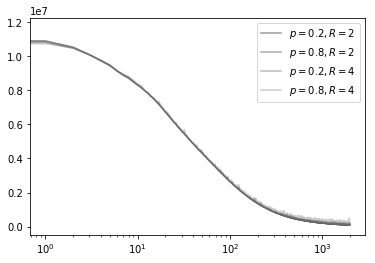

In [7]:
fig, ax = plt.subplots(1)
colours = np.linspace(0, 0.5, len(args))
for i in range(len(args)):
    ax.plot(
        nets[i].loss, 
        "k-", 
        label=r"$p={}, R={}$".format(args[i][7], args[i][8]), 
        color=str(colours[i]), 
        alpha=0.4
    )
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

## Characterising the effects of $p$ and $R$

As both $p$ and $R$ increase, our support vector machines are less able to reliably converge upon the minima they seek.
This is because the scale of the gradient information is more important as we approach the sensative area of the optimal value.

And an efficient approach is to apply some sort of filter to compare the expected behviour with the actual behaviour of the learning progress, e.g. with a Kalman filter.

## Decentralised subgradient descent

In [8]:
def train_dsgd(net, input_data, output_data, n_agents, learning_rate=1e-4, episodes=2000, gpu=False, p=0.9, R=2):
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # optimiser
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # make the agents' batches
    input_batches = input_data.float().chunk(n_agents)
    output_batches = output_data.float().chunk(n_agents)
    
    # put everything on the GPU if you want
    if gpu:
        net.cuda()
        input_batches = [idat.cuda() for idat in input_batches]
        output_batches = [odat.cuda() for odat in output_batches]
        
    # bernoulli probability and gaussian distribution
    p = torch.distributions.bernoulli.Bernoulli(p)
    R = torch.distributions.normal.Normal(0, R)
    
    # for each training episodes
    for e in range(episodes):
        
        # zero the gradients
        opt.zero_grad()
        
        # average loss
        avgloss = 0
        

        # first star
        for idat, odat in zip(input_batches[:4], output_batches[:4]):
            
            # compute the loss for this guy
            loss = torch.mean(torch.pow(torch.norm(net(idat) + R.sample()*p.sample() -odat, 2, dim=1), 2))
            
            # accumulate gradients
            loss.backward()
            
            # record loss
            avgloss += loss.item()
            
        opt.step()
        opt.zero_grad()
            
        
        # second star
        for idat, odat in zip(input_batches[6:], output_batches[6:]):
            
            # compute the loss for this guy
            loss = torch.mean(torch.pow(torch.norm(net(idat) + R.sample()*p.sample() -odat, 2, dim=1), 2))
            
            # accumulate gradients
            loss.backward()
            
            # record loss
            avgloss += loss.item()
            
        opt.step()
              
        
        # record loss
        net.loss.append(avgloss/n_agents)
        
        # a nice little message 
        print("Episode {}; Average Loss = {}".format(e, avgloss/n_agents))
        
    return net.cpu()

In [ ]:
# list of (p, R) values
args = [
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.2, 2),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.8, 2),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.2, 4),
    (SVM(), idat, odat, 10, 1e-4, 2000, True, 0.8, 4)
]

nets = mp.Pool(8).starmap(train_dsgd, args)

# Visualising our training

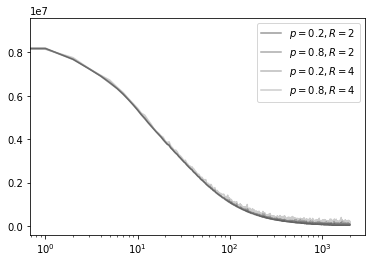

In [10]:
fig, ax = plt.subplots(1)
colours = np.linspace(0, 0.5, len(args))
for i in range(len(args)):
    ax.plot(
        nets[i].loss, 
        "k-", 
        label=r"$p={}, R={}$".format(args[i][7], args[i][8]), 
        color=str(colours[i]), 
        alpha=0.4
    )
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

## Characterising the effects of $p$ and $R$

As before, both $p$ and $R$ increase, our support vector machines are less able to reliably converge upon the minima they seek.

With respect to outliers, we should consider loss functions which do not severely disparage the performance of our support vector machines' training performances; one more suitable approach is to make use of a loss function that measures absolute loss.

With respect to robustness, again, the implementation of a filter of some sort may prove to be usefull in the training performances.

In both cases, we would choose to protect the workers whose datasets include the most outliers, as it is important not to mischaracterise data with more influence.